In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
train_data = pd.read_csv('C:/Users/Public/Documents/titanic/train.csv')
gender_data=pd.read_csv('C:/Users/Public/Documents/titanic/gender_submission.csv')
real_data=pd.read_csv('C:/Users/Public/Documents/titanic/test.csv')

del train_data['PassengerId']
del train_data['Cabin']
del real_data['PassengerId']
del train_data['Ticket']
del real_data['Ticket']
del train_data['Name']
del real_data['Name']

TR=pd.concat([train_data,real_data])
nulT=train_data['Age'].isnull().sum()
nulR=real_data['Age'].isnull().sum()
ag=TR['Age'].dropna().values
fillT = [random.choice(ag) for x in range(nulT)]
fillR = [random.choice(ag) for x in range(nulR)]
train_data.loc[train_data.Age.isnull(), 'Age'] = fillT

real_data.loc[real_data.Age.isnull(), 'Age'] = fillR
#train_data = train_data['Embarked'].dropna()

In [15]:
cat_cols=['Sex','Pclass','Parch','SibSp']
cont_cols=['Fare','Age']
y_col=['Survived']
train_data=train_data.dropna()


In [16]:
for cat in cat_cols:
    train_data[cat] = train_data[cat].astype('category')
    real_data[cat] = real_data[cat].astype('category')

In [17]:
sx1= train_data['Sex'].cat.codes.values
#eb1= train_data['Embarked'].cat.codes.values
pc1= train_data['Pclass'].cat.codes.values
pa1= train_data['Parch'].cat.codes.values
sb1= train_data['SibSp'].cat.codes.values

sx2= train_data['Sex'].cat.codes.values
#eb2= real_data['Embarked'].cat.codes.values
pc2= real_data['Pclass'].cat.codes.values
pa2= real_data['Parch'].cat.codes.values
sb2= real_data['SibSp'].cat.codes.values

cats=np.stack([sx1,pc1,pa1,sb1],1)
cats_real=np.stack([sx2,pc2,pa2,sb2],1)
cats = torch.tensor(cats, dtype=torch.int64)
cats_real = torch.tensor(cats_real, dtype=torch.int64)



    


ValueError: all input arrays must have the same shape

In [7]:
conts=np.stack([train_data[col] for col in cont_cols],1)
conts= torch.tensor(conts, dtype= torch.float)
conts_real=np.stack([real_data[col] for col in cont_cols],1)
conts_real= torch.tensor(conts_real, dtype= torch.float)


NameError: name 'cont_cols' is not defined

In [6]:
y= torch.tensor(train_data[y_col].values).flatten()
batch_size = 880
test_size =260

cats_train = cats[:batch_size-test_size]
cats_test = cats[batch_size-test_size:batch_size]
conts_train = conts[:batch_size-test_size]
conts_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]


NameError: name 'train_data' is not defined

In [5]:
cat_szs = [len(train_data[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_size

NameError: name 'cat_cols' is not defined

In [3]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Attributi per embedding,normalizzazione e dropout
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # lista layers
        layerlist = []
        
        # numero emb e numero variabili continue
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # crea i layers lineat->activation->norm->dropout
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
                        
            #layerlist.append(nn.Dropout(p))
             
           
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # attrinuto layers
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # prende parametri emb dai dati
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # embedding e drop delle variabili categoria
        #x = self.emb_drop(x)
        
        # batch norm delle variabili continue
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # hidden layers
        x = self.layers(x)
        return x

In [4]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts_train.shape[1], 2, [6,3],p=0.4)
model

NameError: name 'emb_szs' is not defined

In [776]:
 criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [777]:
import time
start_time = time.time()

epochs = 150
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    
        
    # Apply the model
    y_pred = model(cats_train, conts_train)  # Here we flatten X_train
    predicted = torch.max(y_pred.data, 1)[1]
    loss = criterion(y_pred, y_train)
 
    # Tally the number of correct predictions
       
        
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr
        
        # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        # Print interim results
    if i%10 == 0:
        print(f'epoch: {i:2}   loss: {loss.item():10.8f}\
        accuracy: {(trn_corr.item()*100)/len(y_pred):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        # Apply the model
        y_val = model(cats_test, conts_test)  # Here we flatten X_test

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1] 
        tst_corr += (predicted == y_test).sum()

        # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            


epoch:  0   loss: 0.84857178        accuracy:  36.290%
epoch: 10   loss: 0.74802405        accuracy:  38.871%
epoch: 20   loss: 0.68835461        accuracy:  62.419%
epoch: 30   loss: 0.64587235        accuracy:  65.806%
epoch: 40   loss: 0.60250783        accuracy:  70.968%
epoch: 50   loss: 0.55204582        accuracy:  78.548%
epoch: 60   loss: 0.51345921        accuracy:  79.032%
epoch: 70   loss: 0.48779827        accuracy:  79.516%
epoch: 80   loss: 0.46968254        accuracy:  80.000%
epoch: 90   loss: 0.45672190        accuracy:  80.484%
epoch: 100   loss: 0.44666427        accuracy:  80.645%
epoch: 110   loss: 0.43838236        accuracy:  81.452%
epoch: 120   loss: 0.43220949        accuracy:  81.452%
epoch: 130   loss: 0.42755973        accuracy:  81.129%
epoch: 140   loss: 0.42346001        accuracy:  82.097%

Duration: 5 seconds


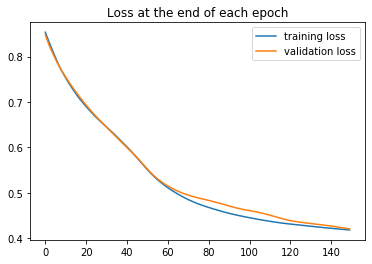

In [711]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [712]:
with torch.no_grad():
    y_val = model(cats_test, conts_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')
    

CE Loss: 0.42054760


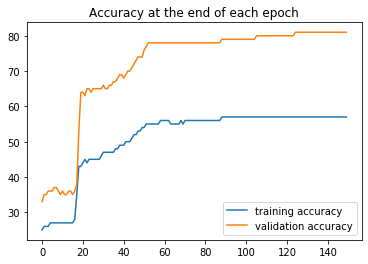

In [713]:
plt.plot([(t*100)/batch_size for t in train_correct], label='training accuracy')
plt.plot([(t*100)/test_size for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [714]:
print('test_correct') # contains the results of all 10 epochs

print(f'Test accuracy: {tst_corr.item()*100/len(y_test):.3f}%')

test_correct
Test accuracy: 81.154%


In [639]:
if len(train_losses) == epochs:
    torch.save(model.state_dict(), 'MyFirstTita.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [636]:
model2= TabularModel(emb_szs, conts_real.shape[1], 2, [4,2],p=0.4)

In [637]:
model2.load_state_dict(torch.load('MyFirstTita.pt'));

RuntimeError: Error(s) in loading state_dict for TabularModel:
	size mismatch for layers.0.weight: copying a param with shape torch.Size([6, 13]) from checkpoint, the shape in current model is torch.Size([4, 13]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for layers.2.weight: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for layers.2.running_mean: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for layers.2.running_var: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for layers.3.weight: copying a param with shape torch.Size([3, 6]) from checkpoint, the shape in current model is torch.Size([2, 4]).
	size mismatch for layers.3.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for layers.5.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for layers.5.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for layers.5.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for layers.5.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for layers.6.weight: copying a param with shape torch.Size([2, 3]) from checkpoint, the shape in current model is torch.Size([2, 2]).

In [638]:
y_valr = model(cats_real, conts_real)
predicted = torch.max(y_valr.data, 1)[1]

RuntimeError: index out of range: Tried to access index 7 out of table with 6 rows. at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensorEvenMoreMath.cpp:418

In [640]:
train_data['Parch']

0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    2
889    0
890    0
Name: Parch, Length: 891, dtype: category
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]